## **Section 1: Imports**

In [28]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (12, 6)

## **Section 2: Functions**

In [4]:
# Feature Engineering
def feature_engineering(sales_data, lag_range=12):
    # Converting 'date' to datetime and creating 'year_month'
    sales_data['date'] = pd.to_datetime(sales_data['date'])
    sales_data['year_month'] = sales_data['date'].dt.to_period('M')

    # Aggregating sales data monthly
    monthly_aggregated_data = sales_data.groupby(['year_month'])['sales'].agg(total_sales=('sum')).reset_index()
    monthly_aggregated_data.set_index('year_month', inplace=True)

    # Calculating the difference for 'total_sales'
    monthly_aggregated_data['total_sales_diff'] = monthly_aggregated_data['total_sales'].diff().dropna()

    # Creating lagged columns for 'total_sales_diff'
    for lag in range(1, lag_range + 1):
        monthly_aggregated_data[f'total_sales_diff_lag_{lag}'] = monthly_aggregated_data['total_sales_diff'].shift(lag)

    # Drop rows with NaN values
    monthly_aggregated_data = monthly_aggregated_data.dropna()

    return monthly_aggregated_data

In [5]:
# Splitting dataset in train data and test data
def split_data(data, feature_columns, target_column, test_size=0.2, random_state=42, shuffle=False):
    # Extracting features and target variable
    X = data.loc[:, feature_columns]
    y = data.loc[:, target_column]

    # Splitting into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=random_state)

    return X, y, X_train, X_test, y_train, y_test

In [6]:
# Scaling features and target variable using MinMaxScaler
def scale_data(X_train, X_test, y_train, y_test, feature_range=(-1, 1)):
    # Scaling features using MinMaxScaler
    scaler = MinMaxScaler(feature_range=feature_range)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scaling target variable
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler

In [7]:
# Model training
def train_regressor_model(regressor, X_train, y_train, hyperparameters=None, random_state=42):

  regressor.set_params(random_state=random_state)
  if hyperparameters:
      model = regressor.set_params(**hyperparameters)
  else:
      model = regressor

  model.fit(X_train, y_train)
  return model

In [8]:
# Tuning the data model
def tune_it(estimator, X_train, y_train, param_grid, random_state=42, scoring='neg_mean_absolute_error', n_splits=3, verbose=2, n_jobs=-1):

    estimator.set_params(random_state=random_state)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    grid_search = GridSearchCV(estimator, param_grid=param_grid, scoring=scoring, cv=tscv, verbose=verbose, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_


In [9]:
# Evaluating the model
def evaluate_model(model, X_test_scaled, y_test_scaled):
    # Predictions
    y_test_pred_scaled = model.predict(X_test_scaled)

    # Calculating regression metrics
    mae = mean_absolute_error(y_test_scaled, y_test_pred_scaled)
    mse = mean_squared_error(y_test_scaled, y_test_pred_scaled)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_scaled - y_test_pred_scaled) / y_test_scaled)) * 100
    smape = (2 * np.mean(np.abs(y_test_pred_scaled - y_test_scaled) / (np.abs(y_test_pred_scaled) + np.abs(y_test_scaled)))) * 100
    r2 = r2_score(y_test_scaled, y_test_pred_scaled)

    results = {
        'y_test_pred': y_test_pred_scaled.tolist(),
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': mape,
        'smape': smape,
        'r2': r2
    }

    return results


In [10]:
# Inverse transformed data and Reverting the differences to forecasted total sales
def inverse_transform_and_revert_differencing(y_pred_scaled, y_last_value, scaler):
    # Obtaining original scale
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # Obtaining forecasted total sales
    forecasted_total_sales = np.cumsum(y_pred)
    forecasted_total_sales += y_last_value

    return forecasted_total_sales

In [11]:
# Print evaluation results
def print_evaluation_results(model_name, results):

    print(f"{model_name} Evaluation on Test Set:")
    print(f'Mean Absolute Error (MAE): {results.get("mae", "N/A")}')
    print(f'Mean Squared Error (MSE): {results.get("mse", "N/A")}')
    print(f'Root Mean Squared Error (RMSE): {results.get("rmse", "N/A")}')
    print(f'Mean Absolute Percentage Error (MAPE): {results.get("mape", "N/A")}%')
    print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {results.get("smape", "N/A")}%')
    print(f'Coefficient of determination (R²): {results.get("r2", "N/A")}')


In [12]:
# Plotting the actual and forecasted monthly total sales
def plot_it(data, predictions, index=None, title='Actual and Forecasted Monthly Total Sales on Test Set'):

    plt.plot(pd.Series(data.loc[y_test.index,:]['total_sales'].values, index=index.astype(str)), label='Actual Monthly Total Sales (Test Set)')
    plt.plot(pd.Series(predictions, index=index.astype(str)), label='Forecasted  Monthly Total Sales', color='orange')

    plt.title(title)
    plt.legend()
    plt.show()

In [13]:
# Create metrics dataframe
def create_metrics_dataframe(results_dict, model_name):
    metrics_data = {
        'Model': [model_name],
        'MAE': [results_dict.get('mae', 'N/A')],
        'MSE': [results_dict.get('mse', 'N/A')],
        'RMSE': [results_dict.get('rmse', 'N/A')],
        'MAPE': [results_dict.get('mape', 'N/A')],
        'SMAPE': [results_dict.get('smape', 'N/A')],
        'R²': [results_dict.get('r2', 'N/A')]
    }

    df = pd.DataFrame(metrics_data)
    return df

In [14]:
# Future forecasting
def predict_next_months(model, features_current, scaler, y_last_value, n_months=3):
    predictions_next_months = []

    for _ in range(n_months):
        current_pred_scaled = model.predict(features_current)

        current_prediction = inverse_transform_and_revert_differencing(current_pred_scaled,
                                                                       y_last_value,
                                                                       scaler)

        predictions_next_months.append(current_prediction[-1])

        # Next prediction features
        features_current = np.roll(features_current, -1)
        features_current[0, -1] = current_pred_scaled[-1]

    return predictions_next_months

## **Section 3: Execution**

In [15]:
# Load dataset
sales_data = pd.read_csv(data_path, index_col=None)

# Aggregate data
monthly_aggregated_data = feature_engineering(sales_data)

# Split data
feature_columns = [f'total_sales_diff_lag_{lag}' for lag in range(1, 13)]
target_column = ['total_sales_diff']
X, y, X_train, X_test, y_train, y_test = split_data(monthly_aggregated_data, feature_columns, target_column)

# Scale data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler = scale_data(X_train, X_test, y_train, y_test)

# Last features and target variable
features_current = X_test_scaled[-1].reshape(1, -1)
last_total_sales = monthly_aggregated_data['total_sales'][-1]

In [16]:
# Find best hyperparameters --> XGB
param_girds_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0.1, 1, 10],
    'reg_alpha': [0, 0.1, 0.5]
}
best_params_xgb = tune_it(XGBRegressor(), X_train_scaled, y_train_scaled, param_girds_xgb)

Fitting 3 folds for each of 19683 candidates, totalling 59049 fits


In [17]:
best_params_xgb

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 50,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.9}

In [18]:
# Find best hyperparameters --> RF
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
best_params_rf = tune_it(RandomForestRegressor(), X_train_scaled, y_train_scaled.ravel(), param_grid_rf)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [19]:
best_params_rf

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [20]:
# Train and Evaluate ---> XGBRegressor
model_xgb = train_regressor_model(XGBRegressor(), X_train_scaled, y_train_scaled, hyperparameters=best_params_xgb)

results_xgb =  evaluate_model(model_xgb, X_test_scaled, y_test_scaled)

forecasted_total_sales_xgb = inverse_transform_and_revert_differencing(np.array(results_xgb['y_test_pred']), last_total_sales, scaler)


In [21]:
print_evaluation_results("XGB", results_xgb)

XGB Evaluation on Test Set:
Mean Absolute Error (MAE): 0.05118558785097421
Mean Squared Error (MSE): 0.00301953194856335
Root Mean Squared Error (RMSE): 0.054950267957156955
Mean Absolute Percentage Error (MAPE): 171.16369871432707%
Symmetric Mean Absolute Percentage Error (SMAPE): 129.73857533846902%
Coefficient of determination (R²): 0.9921976913361688


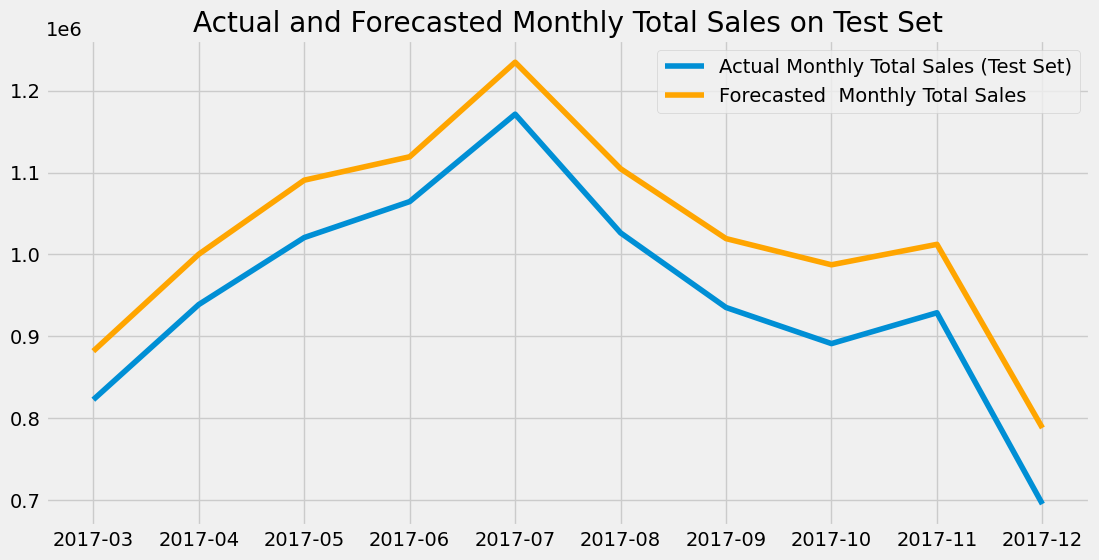

In [22]:
plot_it(monthly_aggregated_data, forecasted_total_sales_xgb, index=y_test.index)

In [23]:
# Train and Evaluate ---> RandomForestRegressor
model_rf = train_regressor_model(RandomForestRegressor(), X_train_scaled, y_train_scaled.ravel(), hyperparameters=best_params_rf)

results_rf =  evaluate_model(model_rf, X_test_scaled, y_test_scaled)

forecasted_total_sales_rf = inverse_transform_and_revert_differencing(np.array(results_rf['y_test_pred']), last_total_sales, scaler)


In [24]:
print_evaluation_results('RF', results_rf)

RF Evaluation on Test Set:
Mean Absolute Error (MAE): 0.07439285109806673
Mean Squared Error (MSE): 0.007339452261694118
Root Mean Squared Error (RMSE): 0.08567060325277345
Mean Absolute Percentage Error (MAPE): 165.3772777089865%
Symmetric Mean Absolute Percentage Error (SMAPE): 129.60494049687154%
Coefficient of determination (R²): 0.9810352488582088


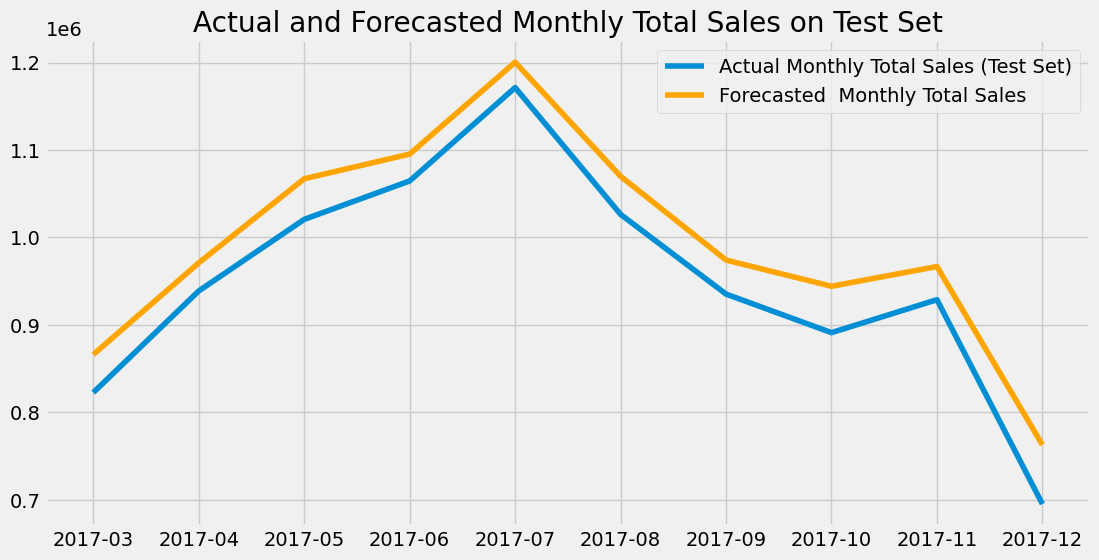

In [25]:
plot_it(monthly_aggregated_data, forecasted_total_sales_rf, index=y_test.index)

In [26]:
# Metrics dataframe
df_xgb = create_metrics_dataframe(results_xgb, 'XGB')
df_rf = create_metrics_dataframe(results_rf, 'RF')
df_metrics = pd.concat([df_xgb, df_rf], ignore_index=True)
df_colored = df_metrics.style.applymap(lambda val: 'background-color: lightcoral' if isinstance(val, (int, float)) and val <= np.min([x for x in df_metrics.values.flatten() if isinstance(x, (int, float))]) else '')
df_colored

,Model,MAE,MSE,RMSE,MAPE,SMAPE,R²
0,XGB,0.051186,0.003020,0.054950,171.163699,129.738575,0.992198
1,RF,0.074393,0.007339,0.085671,165.377278,129.604940,0.981035


In [27]:
# Future forecasting --- 3 Months
predictions_next_3_months_rf = predict_next_months(model_rf, features_current, scaler, last_total_sales)
predictions_next_3_months_xgb = predict_next_months(model_xgb, features_current, scaler, last_total_sales)

print("Forecasted Sales for the Next 3 Months (Random Forest):")
print(predictions_next_3_months_rf)
print()


print("Forecasted Sales for the Next 3 Months (XGBoost):")
print(predictions_next_3_months_xgb)

Forecasted Sales for the Next 3 Months (Random Forest):
[491254.98, 526026.94, 548760.38]

Forecasted Sales for the Next 3 Months (XGBoost):
[470893.7, 504584.6, 524555.44]
